https://github.com/jhanwarakhil/vgg16_transfer_learning/blob/master/vgg_16_fruits.ipynb

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_utils
import numpy as np

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [3]:
# import zipfile as zf #use for unzip files and keep in the same folder w/ manually combine into 1 folder

# # files1 = zf.ZipFile("snake.zip",'r')
# # files1.extractall()
# # files1.close()

# # files2 = zf.ZipFile("non-snake.zip",'r')
# # files2.extractall()
# # files2.close()

# files = zf.ZipFile("dataset.zip",'r')
# files.extractall()
# files.close()

In [4]:
# import splitfolders

# splitfolders.ratio("dataset", output="output", seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)

In [5]:
IMAGE_SIZE = [224, 224] 

# training config:
epochs = 100 #One Epoch is when an Enter dataset is passed forward and backward through the neural network only once
batch_size = 32 #no. of the images that go in each round/ divide dataset into number of batches or set 

In [6]:
train_path = './output_M1A/train_M1A_RM_AUG'
valid_path = './output_M1A/val_M1A_RM'
test_path = './output_M1A/test_M1A_RM' #**************************

In [7]:
Training_path = './output_M1A/train_M1A_RM_AUG/'
Validation_path = './output_M1A/val_M1A_RM/'
Test_path = './output_M1A/test_M1A_RM/'

In [8]:
import os

def number_of_imgs(path):
    print(path)
    for value in os.listdir(path):
        print(value, "has", len(os.listdir(path + value)), "imgs")
    print('\n')
    
    
number_of_imgs(Test_path)
number_of_imgs(Training_path)
number_of_imgs(Validation_path)

./output_M1A/test_M1A_RM/
non-snake has 630 imgs
snake has 630 imgs


./output_M1A/train_M1A_RM_AUG/
non-snake has 5670 imgs
snake has 5670 imgs


./output_M1A/val_M1A_RM/
non-snake has 630 imgs
snake has 630 imgs




In [9]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

print(len(image_files))

11339


In [10]:
def create_dataframe(path):
    data = []
    for value in os.listdir(path):
        for image in os.listdir(path + value + "/"):
            file_path = path + value + "/" + image
            # if snake than set if to 1 else 0
            snake = 1 if value.lower() == "snake" else 0
            data.append({"path": file_path, 'snake': snake})
            
    df = pd.DataFrame(data=data).sample(frac=1).reset_index(drop=True)

    return df

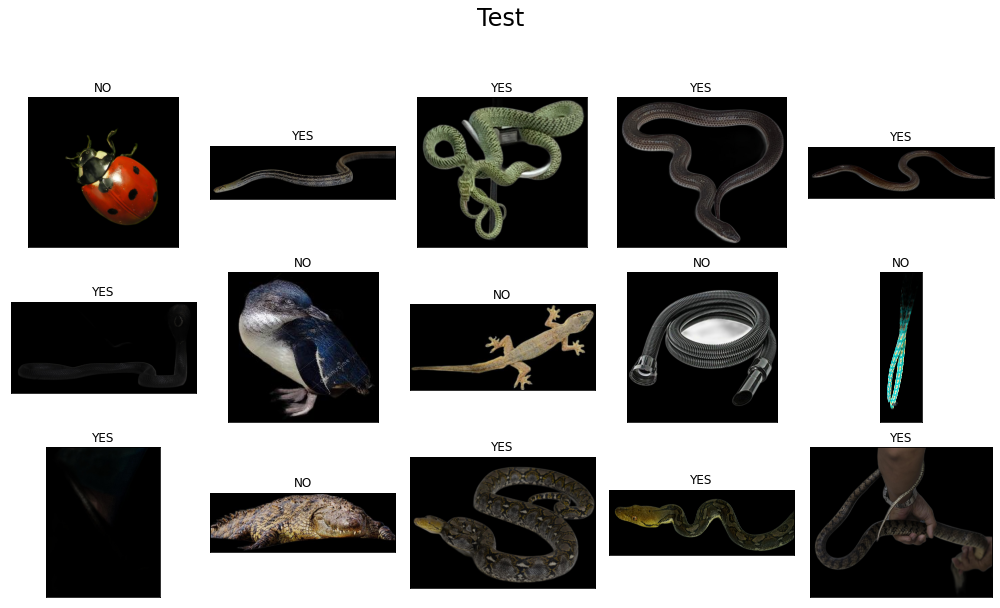

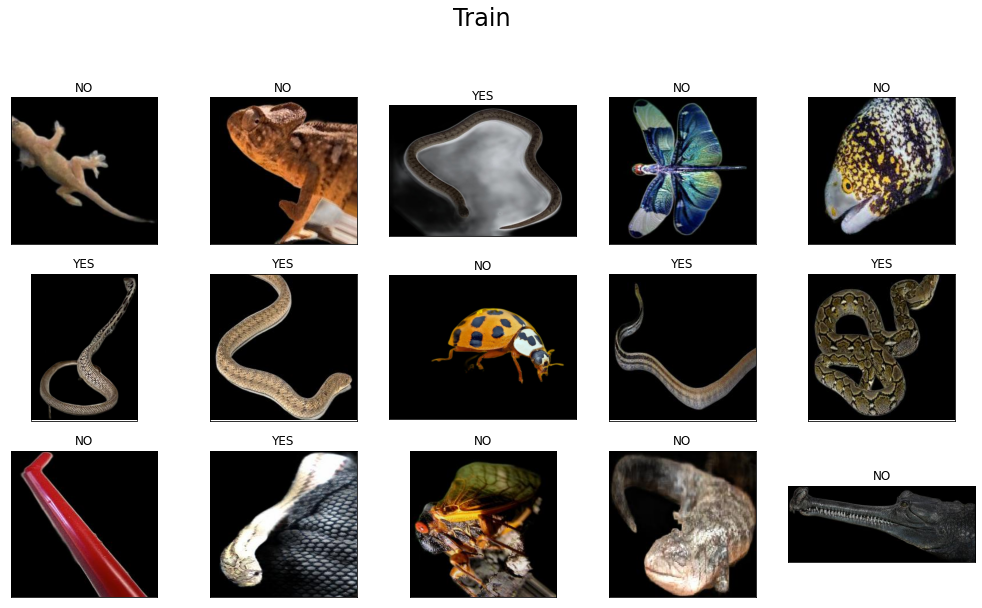

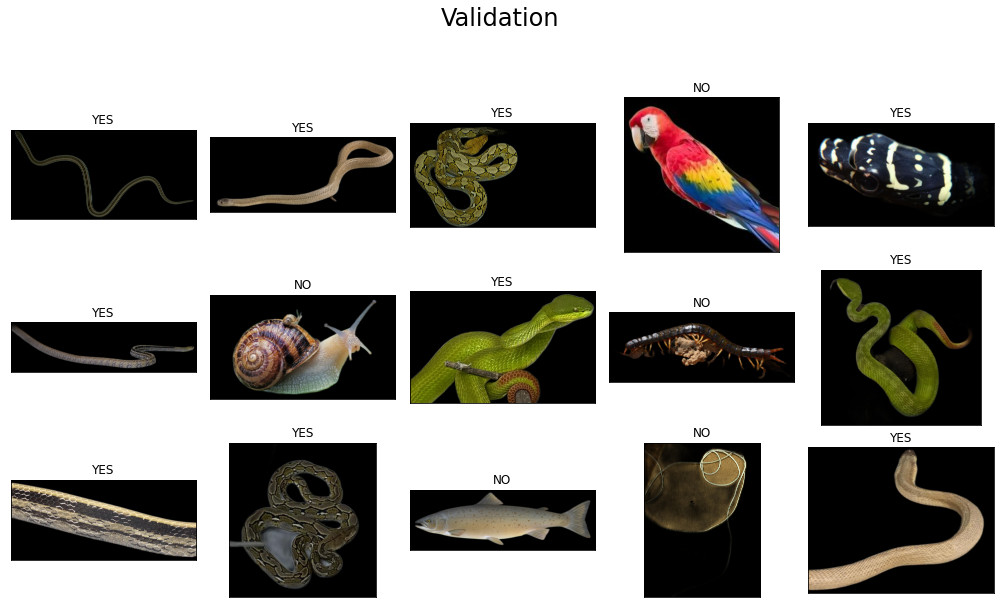

In [11]:
%matplotlib inline
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_imgs(title, paths):
    fig = plt.figure(figsize=(14, 8), dpi=72)
    fig.suptitle(title, fontsize=24, y=1.05)
    for i, row in paths.iterrows():
        img=mpimg.imread(row['path'])
        plt.subplot(3, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        subtitle = 'YES' if row['snake'] == 1 else 'NO'
        plt.title(subtitle)
        plt.imshow(img)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None)
    plt.show()
    
    
plot_imgs("Test", create_dataframe(Test_path).sample(15).reset_index(drop=True))
plot_imgs("Train", create_dataframe(Training_path).sample(15).reset_index(drop=True))
plot_imgs("Validation", create_dataframe(Validation_path).sample(15).reset_index(drop=True))

# Start VGG model

In [12]:
vgg=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))

In [13]:
for layer in vgg.layers:
    layer.trainable =False

In [14]:
x=Flatten()(vgg.output)
prediction=Dense(len(folders),activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Optimizer: rmsprop, SDG, adam, adadelta, adagrad, adamax, nadam, ftrl

In [16]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
gen=ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,zoom_range=0.2,horizontal_flip=True,vertical_flip=True,preprocessing_function=preprocess_input)

In [18]:
test_gen=gen.flow_from_directory(test_path,target_size=IMAGE_SIZE)

Found 1260 images belonging to 2 classes.


In [19]:
labels = [None] * len(test_gen.class_indices)
print(labels)
for k, v in test_gen.class_indices.items():
  labels[v] = k
print(labels[0])

[None, None]
non-snake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.68 max: 122.247246
[1. 0.]


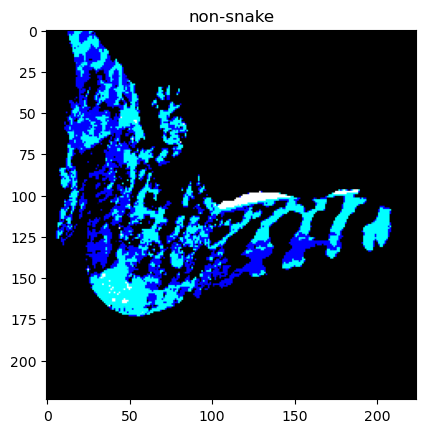

In [20]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  print(y[0])
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [21]:
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 11340 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.


### Model.fit version 1 for specific epochs

In [22]:
# #if you run version 2, do not run this cell

# # download
# import imageio
# imageio.plugins.freeimage.download()

# r = model.fit(
#   train_generator,
#   validation_data=valid_generator,
#   epochs=epochs
# )

### Model.fit version 2 for avg epochs (early stopping)

In [23]:
#if you want to run version 1, do not run this cell

#create callback + early stopping 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = './saved_RM_AUG/M1A_VGG16/VGG16_M1A_RM_AUG_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_weights_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.0001)
callbacks = [early, checkpoint]

#use this when you want early stopping
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
355/355 [==============================] - ETA: 0s - loss: 1.5302 - accuracy: 0.9051
Epoch 1: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1692s 5s/step - loss: 1.5302 - accuracy: 0.9051 - val_loss: 1.4575 - val_accuracy: 0.9349
Epoch 2/100
355/355 [==============================] - ETA: 0s - loss: 1.4261 - accuracy: 0.9266
Epoch 2: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1673s 5s/step - loss: 1.4261 - accuracy: 0.9266 - val_loss: 1.7778 - val_accuracy: 0.9270
Epoch 3/100
355/355 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.9349
Epoch 3: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1686s 5s/step - loss: 1.4585 - accuracy: 0.9349 - val_loss: 2.3416 - val_accuracy: 0.9278
Epoch 4/100
355/355 [==============================] - ETA: 0s - loss: 1.595

355/355 [==============================] - 1664s 5s/step - loss: 1.8224 - accuracy: 0.9572 - val_loss: 2.2365 - val_accuracy: 0.9571
Epoch 28/100
355/355 [==============================] - ETA: 0s - loss: 1.8240 - accuracy: 0.9526
Epoch 28: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1662s 5s/step - loss: 1.8240 - accuracy: 0.9526 - val_loss: 3.0887 - val_accuracy: 0.9389
Epoch 29/100
355/355 [==============================] - ETA: 0s - loss: 1.7991 - accuracy: 0.9588
Epoch 29: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1662s 5s/step - loss: 1.7991 - accuracy: 0.9588 - val_loss: 2.7119 - val_accuracy: 0.9429
Epoch 30/100
355/355 [==============================] - ETA: 0s - loss: 1.7500 - accuracy: 0.9590
Epoch 30: saving model to ./saved_RM_AUG/M1A_VGG16\VGG16_M1A_RM_AUG_model.hdf5
355/355 [==============================] - 1667s 5s/step - loss: 1.750

In [24]:
print ('Training Accuracy = ' + str(r.history['accuracy']))
print ('Validation Accuracy = ' + str(r.history['val_accuracy']))

Training Accuracy = [0.9051146507263184, 0.9266313910484314, 0.934920608997345, 0.9380070567131042, 0.9443562626838684, 0.9405643939971924, 0.9473544955253601, 0.9501763582229614, 0.9514109492301941, 0.9501763582229614, 0.9505290985107422, 0.950264573097229, 0.9494708776473999, 0.9485890865325928, 0.952645480632782, 0.954673707485199, 0.9512345790863037, 0.9585537910461426, 0.9544091820716858, 0.9522927403450012, 0.9545855522155762, 0.956084668636322, 0.9571428298950195, 0.9562610387802124, 0.952645480632782, 0.9558200836181641, 0.9572310447692871, 0.9525573253631592, 0.9588183164596558, 0.9589946866035461, 0.9570546746253967]
Validation Accuracy = [0.934920608997345, 0.9269841313362122, 0.9277777671813965, 0.9444444179534912, 0.9333333373069763, 0.946825385093689, 0.9404761791229248, 0.9492063522338867, 0.9420635104179382, 0.9396825432777405, 0.9444444179534912, 0.9357143044471741, 0.9484127163887024, 0.9309523701667786, 0.9492063522338867, 0.9484127163887024, 0.9396825432777405, 0.94

# Evaluate model

In [25]:
result_val = model.evaluate(valid_generator,batch_size=batch_size)
print("Validation -> Validation loss, Validation accuracy",result_val)

40/40 [==============================] - 169s 4s/step - loss: 2.8754 - accuracy: 0.9468
Validation -> Validation loss, Validation accuracy [2.875403642654419, 0.946825385093689]


In [26]:
result_train = model.evaluate(train_generator,batch_size=batch_size)
print("Training -> Training loss, Training accuracy",result_train)

355/355 [==============================] - 1498s 4s/step - loss: 1.7299 - accuracy: 0.9574
Training -> Training loss, Training accuracy [1.729886770248413, 0.9574074149131775]


In [27]:
result = model.evaluate(test_gen,batch_size=batch_size)
print("Testing -> Test loss, Test accuracy",result)

40/40 [==============================] - 170s 4s/step - loss: 2.9953 - accuracy: 0.9548
Testing -> Test loss, Test accuracy [2.995331287384033, 0.9547619223594666]


# Calculating Reality & Predictions

## Validation & Testing

In [28]:
import cv2
import tensorflow as tf # machine learning
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
import torchvision

IMG_SIZE = (224, 224)

def preprocess_imgs(path, img_size):
    set_new = []
    for value in os.listdir(path):
        for img in os.listdir(path + value):
            img = cv2.imread(path + value + "/" + img)
            img = cv2.resize(
                img,
                dsize=img_size,
                interpolation=cv2.INTER_CUBIC
            )
            set_new.append(tf.keras.applications.vgg16.preprocess_input(img))
    
    return np.array(set_new)

valid_data = preprocess_imgs(Validation_path, img_size=IMG_SIZE)

valid_reality = []
for value in os.listdir(Validation_path):
    for img in os.listdir(Validation_path + value):
        valid_reality.append(1) if value.lower() == "snake" else valid_reality.append(0)
        
valid_predictions = model.predict(valid_data)
# predictions = [0 if x > 0.5 else 1 for x in predictions]
valid_predictions = np.argmax(valid_predictions, axis=1)

accuracy = accuracy_score(valid_reality, valid_predictions)
print("Validation Evaluation Done")


test_data = preprocess_imgs(Test_path, img_size=IMG_SIZE)

test_reality = []
for value in os.listdir(Test_path):
    for img in os.listdir(Test_path + value):
        test_reality.append(1) if value.lower() == "snake" else test_reality.append(0)
        
test_predictions = model.predict(test_data)
# predictions = [0 if x > 0.5 else 1 for x in predictions]
test_predictions = np.argmax(test_predictions, axis=1)

accuracy = accuracy_score(test_reality, test_predictions)
print("Testing Evaluation Done")

40/40 [==============================] - 163s 4s/step
Validation Evaluation Done
40/40 [==============================] - 162s 4s/step
Testing Evaluation Done


# Visualization the result

## Model Performance Graph

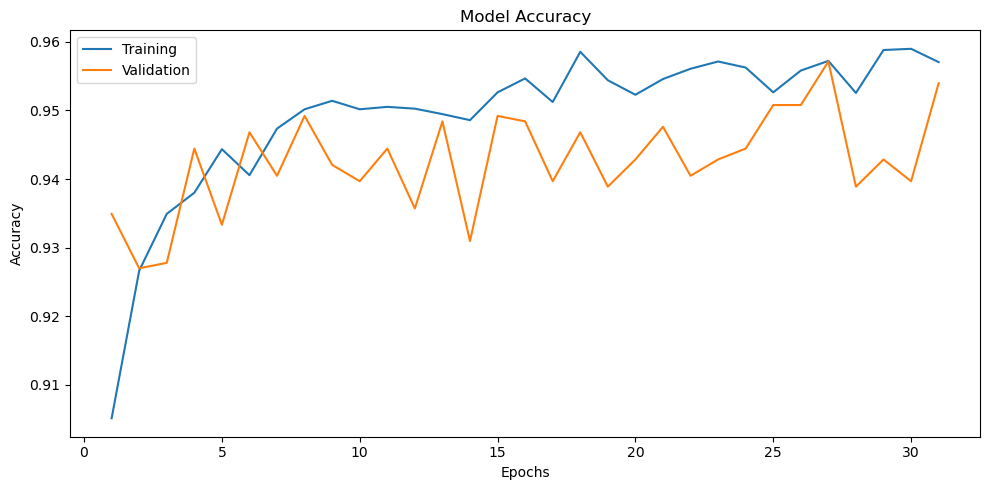

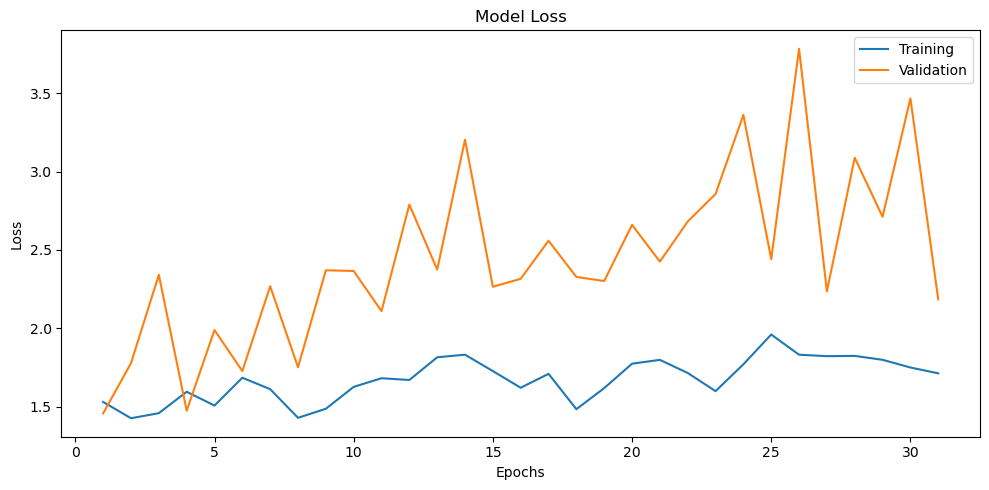

In [29]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs_range = range(1, len(r.epoch) + 1)

#Accuracy
plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.tight_layout()
plt.savefig('./saved_RM_AUG/M1A_VGG16/model-acc-graph.png')
plt.show()

#Loss
plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.savefig('./saved_RM_AUG/M1A_VGG16/model-loss-graph.png')
plt.show()

## Heatmap

### Validation & Testing

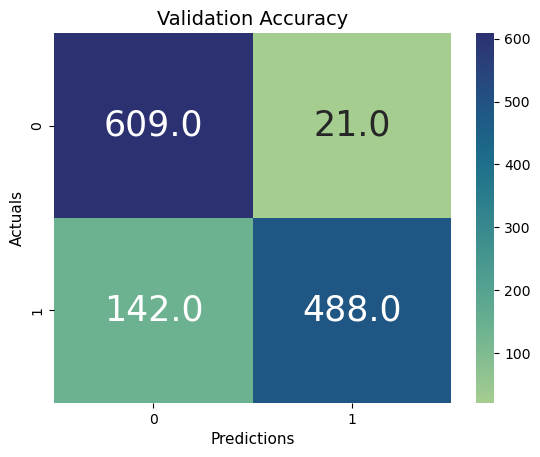

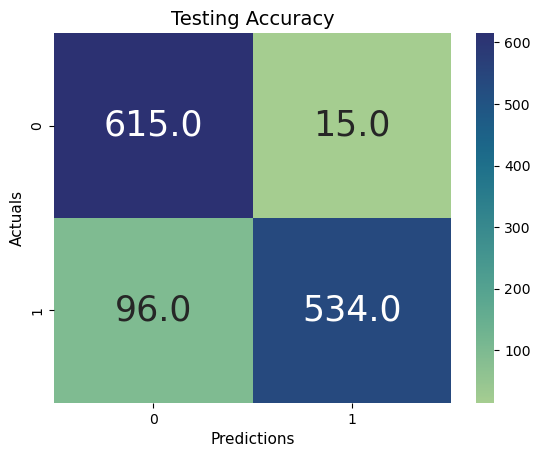

In [30]:
import seaborn as sn

valid_confusion_mtx = confusion_matrix(valid_reality, valid_predictions)

ax = plt.axes()
sn.heatmap(valid_confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="crest", ax = ax, fmt=".1f")
ax.set_title('Validation Accuracy', size=14)
plt.xlabel('Predictions', fontsize=11)
plt.ylabel('Actuals', fontsize=11)
plt.savefig('./saved_RM_AUG/M1A_VGG16/valid-acc-heatmap.png')
plt.show()


test_confusion_mtx = confusion_matrix(test_reality, test_predictions)

ax = plt.axes()
sn.heatmap(test_confusion_mtx, annot=True,annot_kws={"size": 25}, cmap="crest", ax = ax, fmt=".1f")
ax.set_title('Testing Accuracy', size=14)
plt.xlabel('Predictions', fontsize=11)
plt.ylabel('Actuals', fontsize=11)
plt.savefig('./saved_RM_AUG/M1A_VGG16/test-acc-heatmap.png')
plt.show()

In [31]:
from sklearn.metrics import classification_report

print('Classification Report of Validation \n')
target_names = ['non-snake', 'snake']
print(classification_report(valid_reality,valid_predictions, target_names=target_names))

print('Classification Report of Testing \n')
target_names = ['non-snake', 'snake']
print(classification_report(test_reality,test_predictions, target_names=target_names))

Classification Report of Validation 

              precision    recall  f1-score   support

   non-snake       0.81      0.97      0.88       630
       snake       0.96      0.77      0.86       630

    accuracy                           0.87      1260
   macro avg       0.88      0.87      0.87      1260
weighted avg       0.88      0.87      0.87      1260

Classification Report of Testing 

              precision    recall  f1-score   support

   non-snake       0.86      0.98      0.92       630
       snake       0.97      0.85      0.91       630

    accuracy                           0.91      1260
   macro avg       0.92      0.91      0.91      1260
weighted avg       0.92      0.91      0.91      1260



# Evaluation (Accuracy, Precision, Recall, F1-score)

## Validation & Testing

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(valid_reality, valid_predictions)
print('Validation Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(valid_reality, valid_predictions)
print('Validation Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(valid_reality, valid_predictions)
print('Validation Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(valid_reality, valid_predictions)
print('Validation F1 score: %f' % f1)
print('----------------------------------------------------')


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_reality, test_predictions)
print('Testing Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(test_reality, test_predictions)
print('Testing Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(test_reality, test_predictions)
print('Testing Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_reality, test_predictions)
print('Testing F1 score: %f' % f1)

Validation Accuracy: 0.870635
Validation Precision: 0.958743
Validation Recall: 0.774603
Validation F1 score: 0.856892
----------------------------------------------------
Testing Accuracy: 0.911905
Testing Precision: 0.972678
Testing Recall: 0.847619
Testing F1 score: 0.905852


# Showing wrong prediction images

In [33]:
from PIL import Image

def check_image(path, img_size, order):
    k = 0
    for value in os.listdir(path):
        for img in os.listdir(path + value):
            if k == order: 
                return img
            k = k+1

## Validation

In [34]:
print('This is the wrong prediction of validation set')
i = 0
for value in valid_predictions:
    if valid_reality[i] != valid_predictions[i]:
        image = check_image(Test_path, img_size=IMG_SIZE, order=i)
        print('reality -> ', valid_reality[i], ' != predictions -> ', valid_predictions[i], ' -----> ', image)
            
    i = i + 1

This is the wrong prediction of validation set
reality ->  0  != predictions ->  1  ----->  AQU_157.jpg
reality ->  0  != predictions ->  1  ----->  AQU_162.jpg
reality ->  0  != predictions ->  1  ----->  AQU_163.jpg
reality ->  0  != predictions ->  1  ----->  AQU_423.jpg
reality ->  0  != predictions ->  1  ----->  AQU_442.jpg
reality ->  0  != predictions ->  1  ----->  AQU_47.jpg
reality ->  0  != predictions ->  1  ----->  INS_127.jpg
reality ->  0  != predictions ->  1  ----->  INS_342.jpg
reality ->  0  != predictions ->  1  ----->  NON_173.jpg
reality ->  0  != predictions ->  1  ----->  NON_179.jpg
reality ->  0  != predictions ->  1  ----->  NON_203.jpg
reality ->  0  != predictions ->  1  ----->  NON_209.jpg
reality ->  0  != predictions ->  1  ----->  NON_333.jpg
reality ->  0  != predictions ->  1  ----->  NON_36.jpg
reality ->  0  != predictions ->  1  ----->  NON_4.jpg
reality ->  0  != predictions ->  1  ----->  NON_512.jpg
reality ->  0  != predictions ->  1  ----->  

## Testing set

In [35]:
print('This is the wrong prediction of testing set')
i = 0
for value in test_predictions:
    if test_reality[i] != test_predictions[i]:
        image = check_image(Test_path, img_size=IMG_SIZE, order=i)
        print('reality -> ', test_reality[i], ' != predictions -> ', test_predictions[i], ' -----> ', image)
            
    i = i + 1

This is the wrong prediction of testing set
reality ->  0  != predictions ->  1  ----->  AQU_155.jpg
reality ->  0  != predictions ->  1  ----->  AQU_469.jpg
reality ->  0  != predictions ->  1  ----->  AQU_480.jpg
reality ->  0  != predictions ->  1  ----->  INS_253.jpg
reality ->  0  != predictions ->  1  ----->  INS_340.jpg
reality ->  0  != predictions ->  1  ----->  INS_343.jpg
reality ->  0  != predictions ->  1  ----->  INS_522.jpg
reality ->  0  != predictions ->  1  ----->  MAM_250.jpg
reality ->  0  != predictions ->  1  ----->  NON_105.jpg
reality ->  0  != predictions ->  1  ----->  NON_114.jpg
reality ->  0  != predictions ->  1  ----->  NON_166.jpg
reality ->  0  != predictions ->  1  ----->  NON_292.jpg
reality ->  0  != predictions ->  1  ----->  NON_466.jpg
reality ->  0  != predictions ->  1  ----->  NON_495.jpg
reality ->  0  != predictions ->  1  ----->  REP_300.jpg
reality ->  1  != predictions ->  0  ----->  BAN_106.jpg
reality ->  1  != predictions ->  0  -----> 

# Save model after training 

In [36]:
# save model and architecture to single file

model.save("./saved_RM_AUG/M1A_VGG16/VGG16_M1A_RM_AUG_model.h5")
print("Saved model to disk")

Saved model to disk


In [37]:
from tensorflow.keras.models import save_model

save_model(model, "./saved_RM_AUG/M1A_VGG16/VGG16_M1A_RM_AUG_model.h5")

# Guess the input image

In [38]:
from tensorflow.keras.models import load_model

model = load_model('./saved_RM_AUG/M1A_VGG16/VGG16_M1A_RM_AUG_model.h5')

In [39]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

1/1 [==============================] - 0s 240ms/step
The predicted output is : non-snake


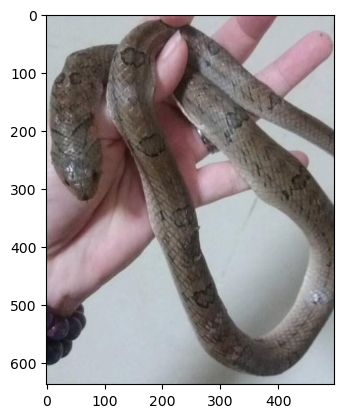

In [40]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_image = tf.keras.utils.load_img(r'./unknown/BAN_352.jpg', color_mode ='rgb',target_size = (224, 224))
test_image = tf.keras.utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

res = np.argmax(result)

dict1 = {0 : 'non-snake', 1: 'snake'}
print("The predicted output is :",dict1[res])

img = mpimg.imread('./unknown/BAN_352.jpg')
imgplot = plt.imshow(img)
plt.show()